# Predicting Fradulent Transactions

# Imports

In [1]:
import numpy as np
import pandas as pd

np.random.seed(69)

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Loading the Data

In [4]:
data = pd.read_csv("./data/Fraud_Data.csv")
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


# Data Analysis

In [4]:
data.shape

(6362620, 11)

In [5]:
data.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

Here are the info about attributes as obtained from `Data_Dictionary.txt`.

`step` - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

`type` - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

`amount` - amount of the transaction in local currency.

`nameOrig` - customer who started the transaction

`oldbalanceOrg` - initial balance before the transaction

`newbalanceOrig` - new balance after the transaction

`nameDest` - customer who is the recipient of the transaction

`oldbalanceDest` - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

`newbalanceDest` - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

`isFraud` - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

This is also the **target** attribute.

`isFlaggedFraud` - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [9]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
step,6362620.0,2.433972e+02,1.423320e+02,1.0,156.00,239.000,3.350000e+02,7.430000e+02
amount,6362620.0,1.798619e+05,6.038582e+05,0.0,13389.57,74871.940,2.087215e+05,9.244552e+07
oldbalanceOrg,6362620.0,8.338831e+05,2.888243e+06,0.0,0.00,14208.000,1.073152e+05,5.958504e+07
newbalanceOrig,6362620.0,8.551137e+05,2.924049e+06,0.0,0.00,0.000,1.442584e+05,4.958504e+07
oldbalanceDest,6362620.0,1.100702e+06,3.399180e+06,0.0,0.00,132705.665,9.430367e+05,3.560159e+08
newbalanceDest,6362620.0,1.224996e+06,3.674129e+06,0.0,0.00,214661.440,1.111909e+06,3.561793e+08
isFraud,6362620.0,1.290820e-03,3.590480e-02,0.0,0.00,0.000,0.000000e+00,1.000000e+00
isFlaggedFraud,6362620.0,2.514687e-06,1.585775e-03,0.0,0.00,0.000,0.000000e+00,1.000000e+00


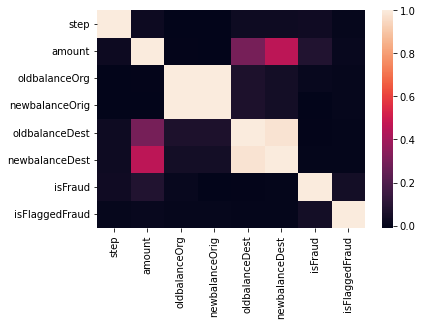

In [8]:
correlations_data = data.corr()
sns.heatmap(correlations_data)
plt.show()

Let's check for missing values first.

In [10]:
data.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Before, we move on to data analysis, we first separate the data into the *frauds* and *non-fraud* data points.

In [12]:
data['isFraud'].unique()

array([0, 1])

In [13]:
fraud_data = data[data['isFraud'] == 1]
non_fraud_data = data[data['isFraud'] == 0]

In [14]:
print("Total no. of fraud data: ", fraud_data.shape[0])
print("Total no. of non-fraud data: ", non_fraud_data.shape[0])

Total no. of fraud data:  8213
Total no. of non-fraud data:  6354407


In [44]:
print("The ratio of non-fraud to fraud customers are:", non_fraud_data.shape[0]/fraud_data.shape[0])

The ratio of non-fraud to fraud customers are: 773.7010836478753


## `step`

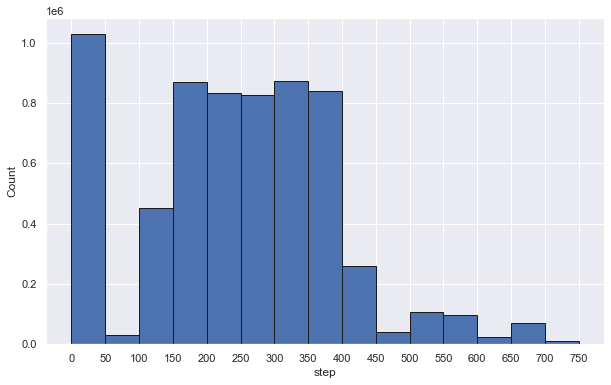

In [32]:
plt.figure(figsize=(10,6))
plt.hist(data['step'], bins=np.arange(0,800,50), align='mid', edgecolor='k')
plt.xticks(np.arange(0,800,50))
plt.xlabel("step")
plt.ylabel("Count")
plt.show()

## `type`

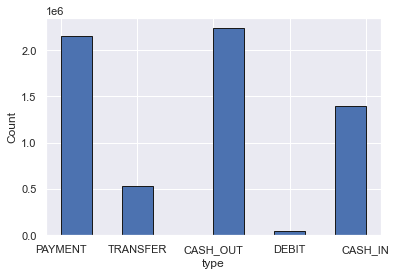

In [49]:
plt.figure(figsize=(6,4))
plt.hist(data['type'], align='mid', edgecolor='k')
plt.xlabel("type")
plt.ylabel("Count")
plt.show()

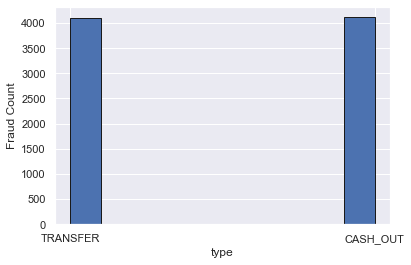

In [50]:
plt.figure(figsize=(6,4))
plt.hist(fraud_data['type'], align='mid', edgecolor='k')
plt.xlabel("type")
plt.ylabel("Fraud Count")
plt.show()

We can see a clear trend here, where most of the fraudelent cases, results in transferring or cashing out on the total amount in the account.

## `amount`

This contains the amount of transaction (in the relevant currency).

In [56]:
data['amount'].describe()

count    6.362620e+06
mean     1.798619e+05
std      6.038582e+05
min      0.000000e+00
25%      1.338957e+04
50%      7.487194e+04
75%      2.087215e+05
max      9.244552e+07
Name: amount, dtype: float64

In [75]:
non_fraud_data['amount'].describe()

count    6.354407e+06
mean     1.781970e+05
std      5.962370e+05
min      1.000000e-02
25%      1.336840e+04
50%      7.468472e+04
75%      2.083648e+05
max      9.244552e+07
Name: amount, dtype: float64

In [74]:
fraud_data['amount'].describe()

count    8.213000e+03
mean     1.467967e+06
std      2.404253e+06
min      0.000000e+00
25%      1.270913e+05
50%      4.414234e+05
75%      1.517771e+06
max      1.000000e+07
Name: amount, dtype: float64

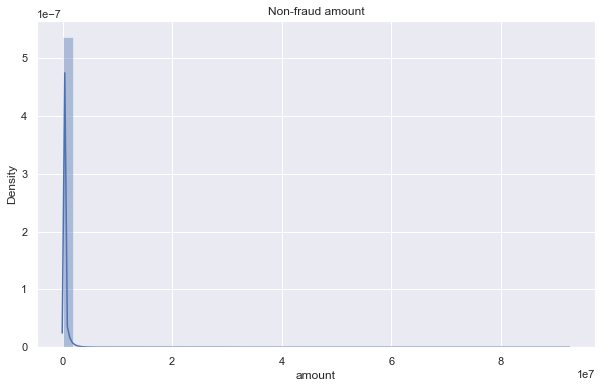

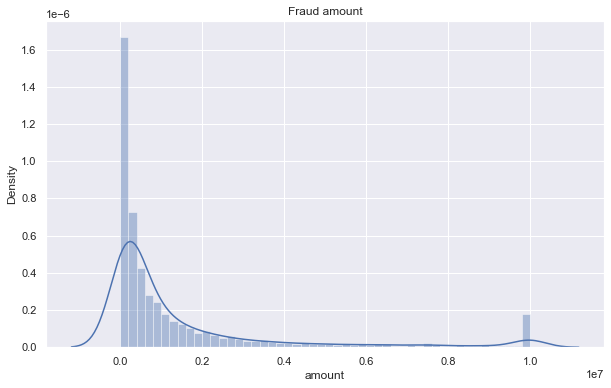

In [86]:
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.distplot(non_fraud_data['amount'])
ax.set_title("Non-fraud amount")

fig, ax = plt.subplots(figsize=(10,6))
ax = sns.distplot(fraud_data['amount'])
ax.set_title("Fraud amount")

plt.show()

As expected, fraud amount has much higher mean and median (almost by a factor of `10`) values as compared to the overall data.

## `oldbalanceOrg`

This contains the initial balance of the sender before the transaction.

In [89]:
non_fraud_data['oldbalanceOrg'].describe()

count    6.354407e+06
mean     8.328287e+05
std      2.887144e+06
min      0.000000e+00
25%      0.000000e+00
50%      1.406900e+04
75%      1.069695e+05
max      4.381886e+07
Name: oldbalanceOrg, dtype: float64

In [91]:
fraud_data['oldbalanceOrg'].describe()

count    8.213000e+03
mean     1.649668e+06
std      3.547719e+06
min      0.000000e+00
25%      1.258224e+05
50%      4.389835e+05
75%      1.517771e+06
max      5.958504e+07
Name: oldbalanceOrg, dtype: float64

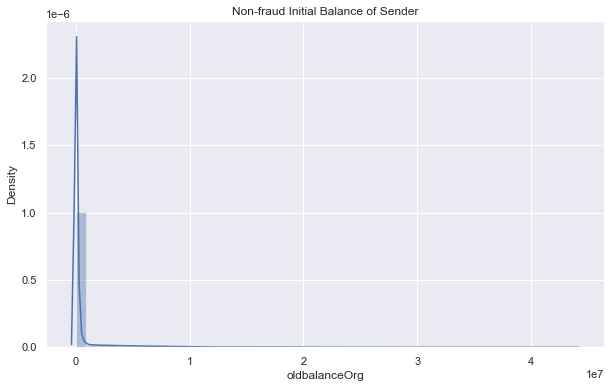

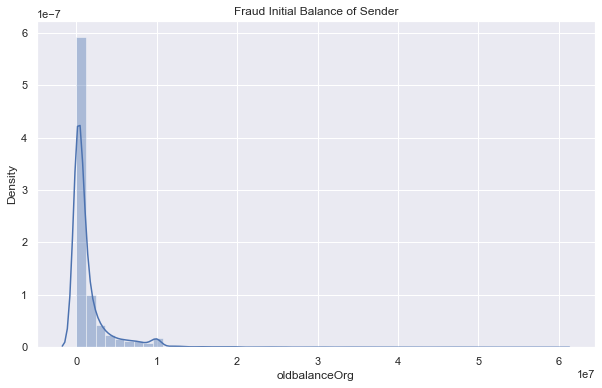

In [87]:
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.distplot(non_fraud_data['oldbalanceOrg'])
ax.set_title("Non-fraud Initial Balance of Sender")

fig, ax = plt.subplots(figsize=(10,6))
ax = sns.distplot(fraud_data['oldbalanceOrg'])
ax.set_title("Fraud Initial Balance of Sender")

plt.show()

As a trend, we see high initial balance in the sender's accounts in fradulent transactions.

## `newbalanceOrig`

This contains the updated balance of the sender after the transaction.

In [92]:
non_fraud_data['newbalanceOrig'].describe()

count    6.354407e+06
mean     8.559702e+05
std      2.924987e+06
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.447307e+05
max      4.368662e+07
Name: newbalanceOrig, dtype: float64

In [93]:
fraud_data['newbalanceOrig'].describe()

count    8.213000e+03
mean     1.923926e+05
std      1.965666e+06
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      4.958504e+07
Name: newbalanceOrig, dtype: float64

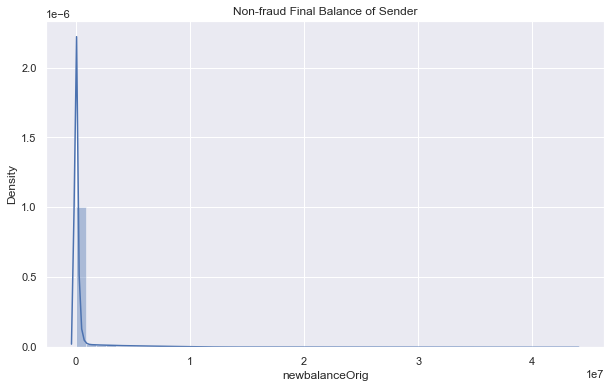

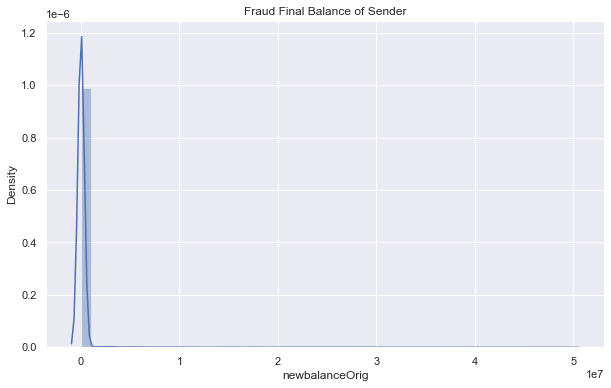

In [88]:
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.distplot(non_fraud_data['newbalanceOrig'])
ax.set_title("Non-fraud Final Balance of Sender")

fig, ax = plt.subplots(figsize=(10,6))
ax = sns.distplot(fraud_data['newbalanceOrig'])
ax.set_title("Fraud Final Balance of Sender")

plt.show()

Again, as expected, the final balance in the sender's account is very less in case of fradulent transactions.

## `isFlaggedFraud`

The business model aims to control massive transfers from one account to another and flags illegal attempts. It marks the transactions as possible fradulent transactions for further enquiry.

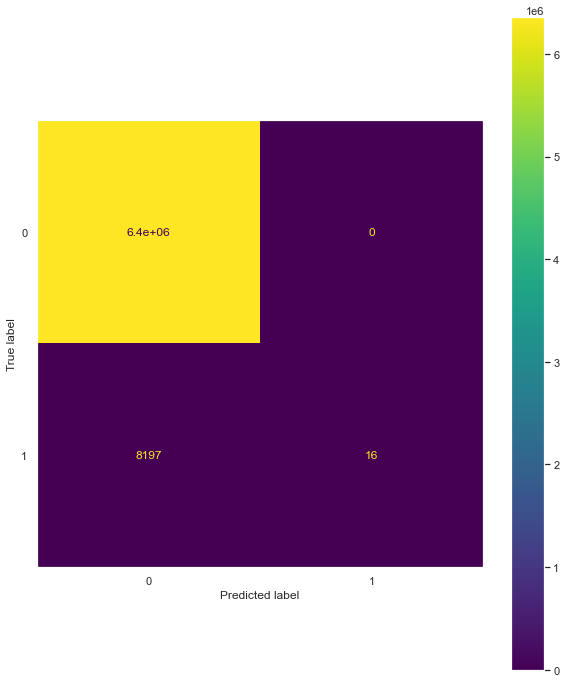

In [122]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(data['isFraud'], data['isFlaggedFraud'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.grid(False)
plt.show()

As we can see from the above matrix, `isFlaggedFraud` is pretty good at eliminating the **False Positive** cases, but still fails miserably at the **False Negative** cases, which we want to improve (which also explains the need of a trained model, rather than just the baseline).

## `isFraud`

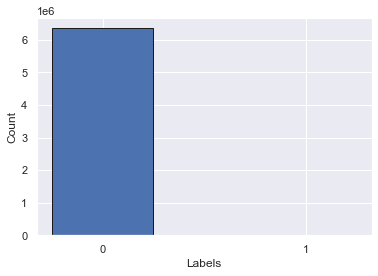

In [124]:
plt.figure(figsize=(6,4))
plt.hist(data['isFraud'],bins=[-0.25,0.25, 0.75,1.25] ,align='mid', edgecolor='k')
plt.xticks([0,1])
plt.xlabel("Labels")
plt.ylabel("Count")
plt.show()

In [125]:
data['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

Clearly, the data is imbalanced. So, a stratified sampling would be required.

# Data Preprocessing

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [13]:
num_col = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud']

type_col = ['type']

In [14]:
combined_pipe = ColumnTransformer([
    ('pass', MinMaxScaler(), num_col),
    ('type', OneHotEncoder(), type_col)
])

In [15]:
from sklearn import set_config
set_config(display='diagram')
combined_pipe

ColumnTransformer(transformers=[('pass', MinMaxScaler(),
                                 ['step', 'amount', 'oldbalanceOrg',
                                  'newbalanceOrig', 'oldbalanceDest',
                                  'newbalanceDest', 'isFlaggedFraud']),
                                ('type', OneHotEncoder(), ['type'])])

In [12]:
data.shape

(6362620, 11)

In [13]:
data_new = combined_pipe.fit_transform(data)
data_new.shape

(6362620, 12)

Now, we put all the relevant preprocessing steps into a single function.

In [16]:
def pre_process(data, test_size=0.25, degree=None):
    from sklearn.compose import ColumnTransformer
    from sklearn.preprocessing import OneHotEncoder,MinMaxScaler , PolynomialFeatures
    from sklearn.model_selection import train_test_split
    
    num_col = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud']

    type_col = ['type']

    combined_pipe = ColumnTransformer([
        ('pass', MinMaxScaler(), num_col),
        ('type', OneHotEncoder(), type_col)
    ])

    data_new = combined_pipe.fit_transform(data)
    target = data['isFraud']
    if degree != None:
        data_new = PolynomialFeatures(degree=degree).fit_transform(data_new)
    
    X_train, X_test, y_train, y_test = train_test_split(data_new, target, stratify=target, test_size=test_size, random_state=69)

    return X_train, X_test, y_train, y_test

In [17]:
X_train, X_test, y_train, y_test = pre_process(data)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4771965, 12) (4771965,)
(1590655, 12) (1590655,)


# Model Selection

Before we move onto training the models on the data, we should first decide on the evaluation metric to focus on. In this scenario, a **False Negative** is very harmful, because we would not want a fradulent transaction to be marked otherwise. So, we should focus on selecting a model with good **Recall**.

Since, the data is unbalanced, we will use the `StratifiedShuffleSplit` with `5` splits as the cross validation strategy.

In [21]:
from sklearn.model_selection import StratifiedShuffleSplit

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=69)

# Training the Model

## XGBoost

In [22]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score
from xgboost import XGBClassifier

clf = XGBClassifier()
scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='recall')

print("%0.2f average train recall with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

clf.fit(X_train, y_train)
y_test_hat = clf.predict(X_test)
print("Test recall of %0.2f" % (recall_score(y_test, y_test_hat)))

[05:28:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:30:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:50:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:30:51] WARNING: /Users/runner/miniforge3/cond

In [23]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_hat))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588602
           1       0.96      0.86      0.91      2053

    accuracy                           1.00   1590655
   macro avg       0.98      0.93      0.96   1590655
weighted avg       1.00      1.00      1.00   1590655



We finally obtain a `recall` of `0.86` on the test data.

# Summary

- We analyse the data, and extract the relevant features.
- We do preprocessing, and select the relevant evaluation metric.
- We use `XGBClassifier` to fit on the data to obtain a respectable `recall_score = 0.86`.